In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import itertools

from config import shuffled_csv, path_exps
from NN import NN_model, Sigmoid, MSE, L2_reg, L1_reg, ReLU
from NN.utility import batch_train, batch_out, Model_Wrapper
from LBFGS import LBFGS
from LevelMethod import LevelMethod
from testing import multi_run


In [2]:
data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:100, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], ReLU, MSE)
model.init_weights()
reg_loss = L1_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights


In [3]:
lambda_ = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
bounds = [1]
HPs = itertools.product(lambda_, bounds)

experiments_csv = path_exps / Path("level_grid_search.csv")
# remove HP combinations already explored
if experiments_csv.exists():
    df = pd.read_csv(experiments_csv)
    HPs_new = []
    for lambda_, bounds in HPs:
        if ((df['lambda_'] == lambda_) & (df['bounds'] == bounds)).any():
            continue
        else:
            HPs_new.append((lambda_, bounds))
    HPs = HPs_new

for lambda_, bounds in HPs:
    print(f'Testing lambda: {lambda_}, bounds: {bounds}', end='\n')
    solver = LevelMethod(lambda_=lambda_, bounds=bounds, max_iter=100000, verbose=False)
    results = multi_run(solver, f, n=3)

    log_columns = ["lambda_", "bounds", "final_fv_m", "final_fv_std", "f_evals_m", "f_evals_std", "seconds_m", "seconds_std", "n_failures"]
    log_data = [lambda_, bounds, results[0], results[1], results[2], results[3], results[4], results[5], results[6]]
    print(results[0])
    df = pd.DataFrame([log_data], columns=log_columns)

    if experiments_csv.exists():
        df.to_csv(experiments_csv, mode="a", header=False,index=False)
    else:
        if not os.path.exists(path_exps):
            os.mkdir(path_exps)
        df.to_csv(experiments_csv,index=False)
    print('\t Finished')

Testing lambda: 0.1, bounds: 1
LevelMethodException Warning: Negative gap -32.64642703260422
101.21914160737748
	 Finished
Testing lambda: 0.2, bounds: 1
LevelMethodException Warning: Negative gap -0.015279970739868531
24.678760091154427
	 Finished
Testing lambda: 0.3, bounds: 1
LevelMethodException Warning: Negative gap -25.278177639960717
11.361357110609532
	 Finished
Testing lambda: 0.4, bounds: 1
LevelMethodException Warning: Negative gap -0.17027631155741219
15.777757014388339
	 Finished
Testing lambda: 0.5, bounds: 1
11.047862951525097
	 Finished
Testing lambda: 0.6, bounds: 1
4.425667225129609
	 Finished
Testing lambda: 0.7, bounds: 1
0.12213773313896327
	 Finished
Testing lambda: 0.8, bounds: 1
0.014067406734335486
	 Finished
Testing lambda: 0.9, bounds: 1
0.011791297865107075
	 Finished


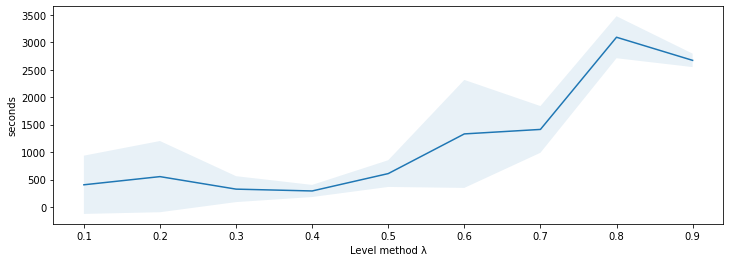

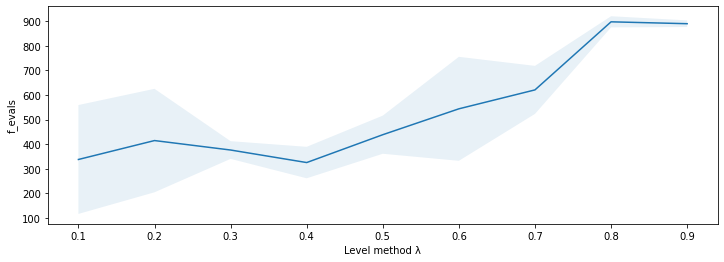

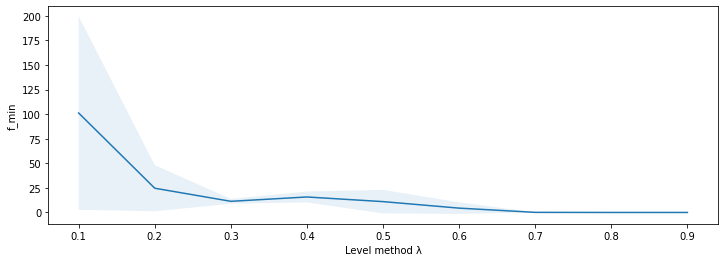

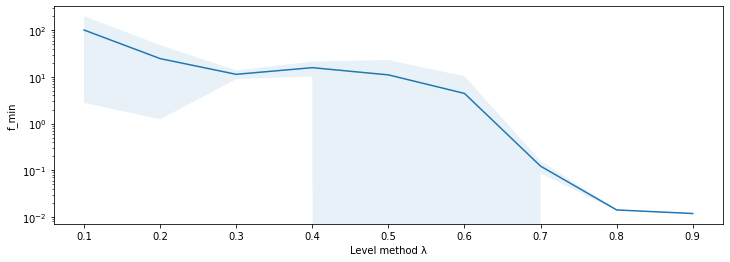

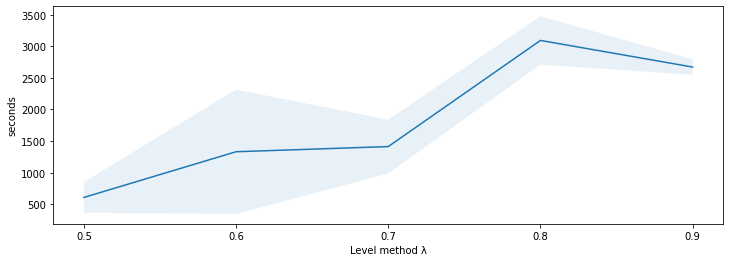

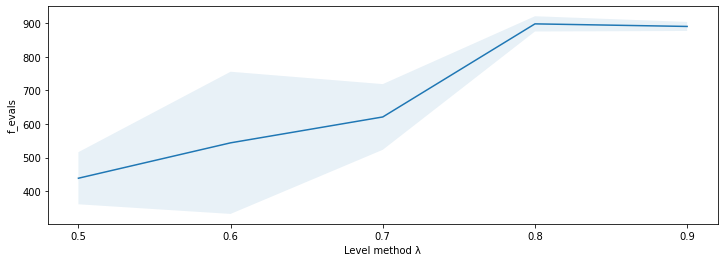

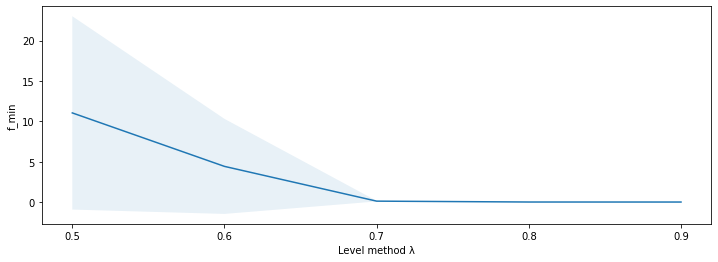

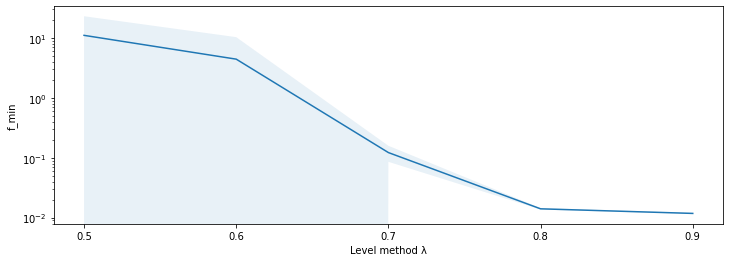

In [7]:
# Plot belli
experiments_csv = path_exps / Path("level_grid_search.csv")
df = pd.read_csv(experiments_csv)
df = df.sort_values(by='lambda_')
x = df['lambda_']

y = df['seconds_m']
y_std = df['seconds_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
ax.set_ylabel('seconds')
ax.set_xlabel('Level method λ')
fig.savefig('plots/level/seconds.png')

y = df['f_evals_m']
y_std = df['f_evals_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
ax.set_ylabel('f_evals')
ax.set_xlabel('Level method λ')
plt.savefig('plots/level/f_evals.png')

y = df['final_fv_m']
y_std = df['final_fv_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
ax.set_ylabel('f_min')
ax.set_xlabel('Level method λ')
plt.savefig('plots/level/f_min.png')


y = df['final_fv_m']
y_std = df['final_fv_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
plt.yscale('log',base=10)
ax.set_ylabel('f_min')
ax.set_xlabel('Level method λ')
plt.savefig('plots/level/f_min_log.png')

# Plots without failures
df = df[df['n_failures'] == 0]
df
x = df['lambda_']
y = df['seconds_m']
y_std = df['seconds_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
ax.set_ylabel('seconds')
ax.set_xlabel('Level method λ')
fig.savefig('plots/level/seconds_nofail.png')

y = df['f_evals_m']
y_std = df['f_evals_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
ax.set_ylabel('f_evals')
ax.set_xlabel('Level method λ')
plt.savefig('plots/level/f_evals_nofail.png')

y = df['final_fv_m']
y_std = df['final_fv_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
ax.set_ylabel('f_min')
ax.set_xlabel('Level method λ')
plt.savefig('plots/level/f_min_nofail.png')


y = df['final_fv_m']
y_std = df['final_fv_std']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xticks(x,x)
plt.yscale('log',base=10)
ax.set_ylabel('f_min')
ax.set_xlabel('Level method λ')
plt.savefig('plots/level/f_min_log_nofail.png', bbox_inches='tight')

In [ ]:
# UNUSED
shapes = [[10,5,5,2], [10,20,20,2], [10,50,50,2]]
optimal_lambda = 0.9

experiments_csv = path_exps / Path("level_models.csv")

for shape in shapes:
    model = NN_model(shape, ReLU, MSE)
    model.init_weights()

    reg_loss = L1_reg(1e-4)

    f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
    x = model.Weights

    print(f'Testing model ', shape)
    solver = LevelMethod(lambda_=optimal_lambda, bounds=1, verbose=False)
    print("È una prova: TOGLI N=1")
    results = multi_run(solver, f, n=1)

    log_columns = ["shape", "lambda_", "final_fv_m", "final_fv_std", "f_evals_m", "f_evals_std", "seconds_m", "seconds_std", "n_failures"]
    log_data = [shape, optimal_lambda, results[0], results[1], results[2], results[3], results[4], results[5], results[6]]
    df = pd.DataFrame([log_data], columns=log_columns)

    if experiments_csv.exists():
        df.to_csv(experiments_csv, mode="a", header=False,index=False)
    else:
        if not os.path.exists(path_exps):
            os.mkdir(path_exps)
        df.to_csv(experiments_csv,index=False)
    print('\t Finished')

In [22]:

solver = LevelMethod(lambda_=0.9, bounds=1, max_iter=100000, verbose=True)

f.model.init_weights()
x = f.model.Weights
solver_out = solver.solve(f, x)


58804	0.013268
418		0.019148	-0.039514		0.058662	0.013282
419		0.019148	-0.038924		0.058072	0.013341
420		0.019148	-0.038450		0.057598	0.013389
421		0.019148	-0.038071		0.057219	0.013426
422		0.019148	-0.037857		0.057005	0.013448
423		0.019148	-0.037763		0.056912	0.013457
424		0.019148	-0.036534		0.055682	0.013580
425		0.019097	-0.036304		0.055400	0.013557
426		0.019097	-0.036041		0.055137	0.013583
427		0.019097	-0.035474		0.054571	0.013640
428		0.019097	-0.035400		0.054497	0.013647
429		0.019097	-0.035267		0.054364	0.013660
430		0.019097	-0.034791		0.053888	0.013708
431		0.019097	-0.034717		0.053813	0.013715
432		0.019097	-0.034337		0.053434	0.013753
433		0.018165	-0.034059		0.052224	0.012943
434		0.018165	-0.033971		0.052136	0.012951
435		0.018165	-0.033254		0.051419	0.013023
436		0.018165	-0.033144		0.051309	0.013034
437		0.018165	-0.032564		0.050729	0.013092
438		0.018165	-0.032440		0.050605	0.013104
439		0.018165	-0.031794		0.049959	0.013169
440		0.018165	-0.031794		0.049959	0.013

In [23]:
logs = solver.logs

y = logs['f_upstar']
x = range(1, len(y)+1)
ax.plot(x,y)
plt.xticks(x,x)
plt.yscale('log',base=10)
ax.set_ylabel(r'f^{*}')
ax.set_xlabel('Level method λ')
plt.savefig('plots/level/f_min_log.png', bbox_inches='tight')

AttributeError: 'LevelMethod' object has no attribute 'logs'